In [20]:
import pandas as pd
import os
import cv2
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import Counter

import torch
from transformers import AutoProcessor, XCLIPVisionModel, AutoModel
from sklearn.metrics import f1_score
from torch.nn import DataParallel
from torch import nn
from torch.nn import CrossEntropyLoss

import matplotlib.pyplot as plt
from IPython.display import clear_output
import time

import random
import numpy as np

### Data Classes

In [5]:
class TestValDataset(Dataset):
    def __init__(self, data, feature_extractor, label2id, clip_len=16, frame_sample_rate=4):
        self.feature_extractor = feature_extractor
        self.label_dict = label2id
        self.data = data

    def __getitem__(self, idx):
        file_path = self.data.iloc[idx]['file_path']
        file_path = f'../../MELDSpeakers/{file_path}'
        all_frames = os.listdir(file_path)
        selected_inds = self.sample_frame_indices(len(all_frames))
        selected_frames = [str(max(i, 0) + 1) + '.png' for i in selected_inds]
        video = []
        for frame in selected_frames:
            image_path = file_path + '/' + frame
            img = cv2.imread(image_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            video.append(img)
        
        assert len(video) == 16, f'Somehow you got a wrong number of frames for video {file_path}!'
    
        encoding = self.feature_extractor(videos=video, return_tensors="pt")

        label = self.label_dict[self.data.iloc[idx]['Emotion']]
        return encoding, label

    def __len__(self):
        return len(self.data)
    
    def sample_frame_indices(self, seg_len, clip_len=16, frame_sample_rate=4):
        # seg_len -- how many frames are received
        # clip_len -- how many frames to return
        converted_len = int(clip_len * frame_sample_rate)
        converted_len = min(converted_len, seg_len-1)
        end_idx = np.random.randint(converted_len, seg_len)
        start_idx = end_idx - converted_len
        indices = np.linspace(start_idx, end_idx, num=clip_len)
        indices = np.clip(indices, start_idx, end_idx - 1).astype(np.int64)
        return indices

In [6]:
def prepare_test_data(bs, feature_extractor):
    full_df = pd.read_csv('../../MELDSpeakers/MELDSpeakers.csv')

    test = full_df[full_df['part'] == 'test']
    
    labels = sorted(list(set(full_df['Emotion'])))
    label2id, id2label = dict(), dict()
    for i, label in enumerate(labels):
        label2id[label] = i
        id2label[i] = label
    
    test_dataset = TestValDataset(test, feature_extractor, label2id)
    test_dataloader = DataLoader(test_dataset, batch_size=bs, shuffle=True)
    
    return len(labels), label2id, id2label, test_dataloader, test_dataset

### Model Classes

In [7]:
class XCLIPClassificaionModel(nn.Module):
    def __init__(self):
        super(XCLIPClassificaionModel, self).__init__()
        
        self.base_model = XCLIPVisionModel.from_pretrained("microsoft/xclip-base-patch32")
        self.num_labels = 7   # hardcoded :(
        
        hidden_size = self.base_model.config.hidden_size
        self.fc_norm = nn.LayerNorm(hidden_size)
        self.classifier = nn.Linear(hidden_size, self.num_labels)
        self.loss_fct = CrossEntropyLoss()
        
        self.pool1 = nn.AdaptiveAvgPool1d(1)
        self.pool2 = nn.AdaptiveAvgPool1d(1)
        
    def forward(self, pixel_values, labels=None):
        
        batch_size, num_frames, num_channels, height, width = pixel_values.shape
        pixel_values = pixel_values.reshape(-1, num_channels, height, width)

        out = self.base_model(pixel_values)[0]  # [48, 50, 768]
        out = torch.transpose(out, 1, 2)        # [48, 768, 50]
        out = self.pool1(out)                   # [48, 768, 1]
        out = torch.transpose(out, 1, 2)        # [48, 1, 768]
        out = out.squeeze(1)                    # [48, 768]
        hidden_out = out.view(batch_size, num_frames, -1)  # [3, 16, 768]
        hidden_out = torch.transpose(hidden_out, 1, 2)     # [3, 768, 16]
        pooled_out = self.pool2(hidden_out)                # [3, 768, 1]
        pooled_out = torch.transpose(pooled_out, 1, 2)     # [3, 1, 768]

        pooled_out = pooled_out[:, 0, :] # [3, 768]
            
        logits = self.classifier(pooled_out)
        
        loss = None
        if labels is not None:
            loss = self.loss_fct(logits.view(-1, self.num_labels), labels.view(-1))
        
        return {'logits': logits, 'loss': loss}

In [8]:
class EmotionClassificationModel():
    
    def __init__(self, model, device):
        self.model = model
        self.device = device
#         self.model.to(device)
        self.model = DataParallel(self.model).to(device)

        
    def __call__(self, pixel_values):
        
        self.model.eval()
        
        with torch.no_grad():
            
            pixel_values = pixel_values.to(self.device)

            output = self.model(pixel_values)
            logits = output['logits']
            
#             active_logits = logits.view(-1, self.model.num_labels)
            active_logits = logits.view(-1, self.model.module.num_labels)
            pred = torch.argmax(active_logits, axis=1)
        return pred
        
    def validate(self, val_dataloader):
        
        self.model.eval()
        
        val_loss, val_fscore = 0, 0
        
        with torch.no_grad():
            for batch in val_dataloader:

                inputs, labels = batch
                pixel_values = inputs['pixel_values'].squeeze(dim=1)
                pixel_values = pixel_values.to(self.device)
                labels = labels.to(self.device)
                
                output = self.model(pixel_values, labels=labels)
                loss = output['loss']
                logits = output['logits']
                
                if torch.cuda.device_count() > 1:
                    loss = loss.mean()

                val_loss += loss.item()

                gold = labels.view(-1)
#                 active_logits = logits.view(-1, self.model.num_labels)
                active_logits = logits.view(-1, self.model.module.num_labels)
                pred = torch.argmax(active_logits, axis=1) 

                fscore = f1_score(gold.cpu().numpy(), pred.cpu().numpy(), average='weighted')
                val_fscore += fscore

        avg_val_loss = val_loss / len(val_dataloader)
        avg_val_f1 = val_fscore / len(val_dataloader)
        return avg_val_loss, avg_val_f1
    
    def train(self, train_dataloader, val_dataloader, n_epoch, optimizer, checkpoint_step, model_save_name, patience):
        
        train_losses, val_losses = [], []
        train_fscores, val_fscores = [], []
        val_scores = []
        no_improv_epochs = 0
                
        for epoch in range(n_epoch):
            
            
            start_time = time.time()
            
            self.model.train()
            
            train_loss, train_fscore = 0, 0
            step_train_losses, step_train_fscores, step_val_losses, step_val_fscores = [], [], [], []
            
            for step_num, batch in enumerate(train_dataloader):
                                
                inputs, labels = batch
                pixel_values = inputs['pixel_values'].squeeze(dim=1)
                pixel_values = pixel_values.to(self.device)
                labels = labels.to(self.device)
                
                output = self.model(pixel_values, labels=labels)
                loss = output['loss']
                logits = output['logits']
                
                
                if torch.cuda.device_count() > 1:
                    loss = loss.mean()
            
                train_loss += loss.item()
                
                self.model.zero_grad()
                loss.backward()
                optimizer.step()

                gold = labels.view(-1)
                active_logits = logits.view(-1, self.model.module.num_labels)
#                 active_logits = logits.view(-1, self.model.num_labels)
                pred = torch.argmax(active_logits, axis=1) 

                fscore = f1_score(gold.cpu().numpy(), pred.cpu().numpy(), average='weighted')
                train_fscore += fscore

#                 wandb.log({"batch train loss": loss.item()})
                
            avg_train_loss = train_loss / len(train_dataloader)
            avg_train_f1 = train_fscore / len(train_dataloader)
            
            # EARLY STOPPING CODE
            avg_val_loss, avg_val_f1 = self.validate(val_dataloader)
            val_scores.append(avg_val_f1)
            if max(val_scores) > avg_val_f1:
                no_improv_epochs += 1
            else:
                torch.save(self.model.module.state_dict(), 'XCLIP_Augmented.pt')
            
            if no_improv_epochs > patience:
                return None
            
            train_losses.append(avg_train_loss)
            train_fscores.append(avg_train_f1)
            val_losses.append(avg_val_loss)
            val_fscores.append(avg_val_f1)
                        
            wandb.log({"train loss": avg_train_loss, "val loss": avg_val_loss, 
                       "train F1": avg_train_f1, "val F1": avg_val_f1,
                       "epoch": epoch}) 
        return None

In [12]:
def test(test_dataloader, answer_model):
    gold, pred = [], []
    for batch in tqdm(test_dataloader):
        a, b = batch
        res = answer_model(a['pixel_values'].squeeze(1))
        pred.extend(res.tolist())
        gold.extend(b.tolist())
    fscore = f1_score(gold, pred, average='weighted')
    return fscore, gold, pred

### Read data

In [10]:
feature_extractor = AutoProcessor.from_pretrained("microsoft/xclip-base-patch32")

num_labels, label2id, id2label, test_dataloader, test_dataset = prepare_test_data(16, feature_extractor)

### Load model

In [13]:
model = XCLIPClassificaionModel()
model.load_state_dict(torch.load("XCLIP_Augmented.pt"))

device = 'cuda'
answer_model = EmotionClassificationModel(model, device=device)

Some weights of the model checkpoint at microsoft/xclip-base-patch32 were not used when initializing XCLIPVisionModel: ['text_model.encoder.layers.9.layer_norm2.bias', 'mit.encoder.layers.0.layer_norm2.weight', 'text_model.final_layer_norm.bias', 'text_model.encoder.layers.6.mlp.fc1.weight', 'mit.encoder.layers.0.self_attn.out_proj.weight', 'text_model.encoder.layers.4.mlp.fc2.weight', 'text_model.encoder.layers.1.layer_norm1.bias', 'text_model.encoder.layers.3.self_attn.q_proj.weight', 'text_model.encoder.layers.9.self_attn.out_proj.bias', 'text_model.encoder.layers.11.mlp.fc1.weight', 'text_model.encoder.layers.11.layer_norm1.bias', 'text_model.encoder.layers.11.mlp.fc2.bias', 'text_model.encoder.layers.4.self_attn.q_proj.bias', 'text_model.encoder.layers.4.mlp.fc2.bias', 'text_model.encoder.layers.9.self_attn.k_proj.bias', 'text_model.encoder.layers.11.self_attn.k_proj.weight', 'text_model.encoder.layers.6.self_attn.v_proj.weight', 'text_model.encoder.layers.10.mlp.fc1.weight', 'pro

### Run Tests

In [15]:
best_fscore, gold, pred = test(test_dataloader, answer_model)

100%|█████████████████████████████████████████████████████████████████████████████████| 156/156 [21:28<00:00,  8.26s/it]


In [16]:
print(f'F score: {best_fscore:.4f}')

F score: 0.3833


### Confusion Matrix

In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter

In [18]:
gold_l = [id2label[g] for g in gold]
pred_l = [id2label[g] for g in pred]
labels = list(set(gold_l))

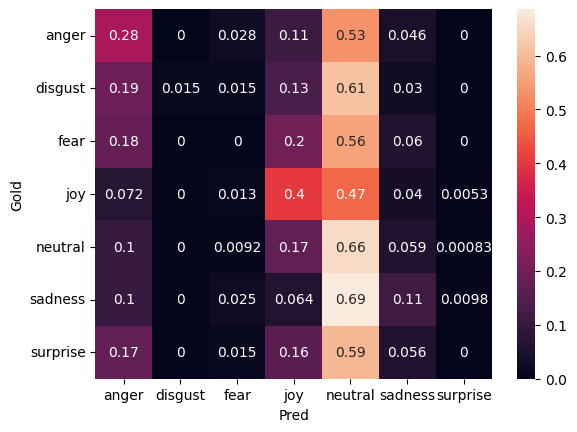

In [19]:
cf_matrix = confusion_matrix(gold, pred, normalize='true')
sns.heatmap(cf_matrix, annot=True, xticklabels=sorted(labels), yticklabels=sorted(labels))
plt.ylabel('Gold')
plt.xlabel('Pred')
plt.show()